In [1]:
%cd ../../..

D:\myrepos\Audio_inpainting


## Example Track

In [2]:
from ielab_audio.data.musdb_wrapper.preprocessed_datasets import FiledMusdbValidSet
import IPython.display as ipd

musdb_root='../data/musdb18_wav'
musdb_is_wave = True
n_fft=2048
hop_length=1024
num_frame=128
target_names=['vocals']

dataset = FiledMusdbValidSet(musdb_root, musdb_is_wave, n_fft, hop_length, num_frame, target_names)
mixture, _, _, _, target_name, singing_voice = dataset[50]

print('mixture shape:{}, target_name:{}, singing_voice shape:{}'.format(mixture.shape, target_name, singing_voice.shape))
ipd.Audio(mixture.detach().numpy().T, rate=44100)

C:\Users\Woosung Choi\miniconda3\envs\cunet_pytorch\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Unsupported `ReduceOp` for distributed computing.
  warnings.warn(*args, **kwargs)
D:\myrepos\Audio_inpainting\ielab_audio\data\musdb_wrapper\preprocessed_datasets.py:131: UserWarning: Librosa Musdbset does not need to be cached.
  warn('Librosa Musdbset does not need to be cached.')


mixture shape:torch.Size([130048, 2]), target_name:vocals, singing_voice shape:torch.Size([130048, 2])


## Spectrogram-based models

- Audio Equalizer - Eliminate signals with unwanted frequencies
![](imgs/eq.png)

- Procedure
  1. Apply Short-Time Fourier Transform (STFT) on a mixture waveform to obtain the input spectrograms.
  2. Estimate the vocal spectrograms based on these inputs 
  3. Restore the vocal waveform with inverse STFT (iSTFT).

### 1. Apply Short-Time Fourier Transform (STFT) on a mixture waveform to obtain the input spectrograms.

```python
def to_spec_complex(self, input_signal: torch.Tensor):
    """
    input_signal: *, signal
    output: *, N, T, 2
    """
    # if input_signal.dtype != self.window.dtype or input_signal.device != self.window.device :
    #     self.window = torch.as_tensor(self.window, dtype=input_signal.dtype, device=input_signal.device)
    # else:
    #     window = self.window

    return torch.stft(input_signal, self.n_fft, self.hop_length, window=self.window)
```

In [3]:
# 1. Apply Short-Time Fourier Transform (STFT) on a mixture waveform to obtain the input spectrograms.

from ielab_audio.utils.fourier import multi_channeled_STFT

stft = multi_channeled_STFT(n_fft=2048, hop_length=1024)
M_complex = stft.to_spec_complex(mixture)

print('mixture shape:{}\nM_complex shape:{}'.format(mixture.shape, M_complex.shape))

mixture shape:torch.Size([130048, 2])
M_complex shape:torch.Size([1025, 128, 2, 2])


####  Visualization

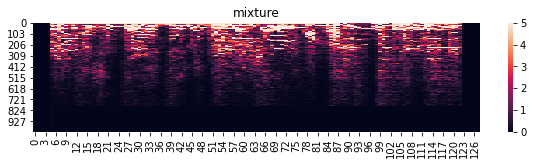

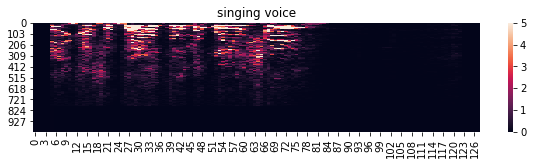

In [4]:
M_mag = stft.to_mag(mixture)
T_mag = stft.to_mag(singing_voice)

import seaborn
import matplotlib.pyplot as plt
plt.figure(figsize=(10,2))
plt.title('mixture')
seaborn.heatmap(M_mag[:,:,0].detach().numpy(), vmax=5)
plt.show()
plt.figure(figsize=(10,2))
plt.title('singing voice')
seaborn.heatmap(T_mag[:,:,0].detach().numpy(), vmax=5)
plt.show()

### 2. Estimate the vocal spectrograms based on these inputs

<AxesSubplot:title={'center':'estmated singing voice (not trained)'}>

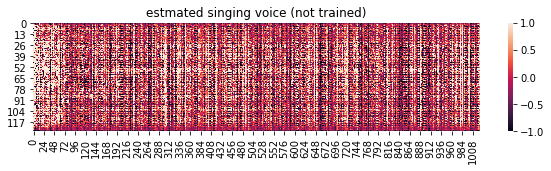

In [5]:
from ielab_audio.models.one2one_separation import TFC_TDF_NET_Framework

params = {'n_blocks':3, 'input_channels':4, 'internal_channels':4, 'n_internal_layers':3, 
          'first_conv_activation':'relu', 'last_activation':'identity',            
          't_down_layers':None, 'f_down_layers':None,
          'kernel_size_f':3, 'kernel_size_t':3,
          'bn_factor':16, 'min_bn_units':16, 'tfc_tdf_bias':False, 
          'tfc_tdf_activation':'relu',
          'tif_init_mode':None}

tfc_tdf_net = TFC_TDF_NET_Framework(
    target_name='vocals',
    n_fft=2048, hop_length=1024, num_frame=128,
    spec_type='complex', spec_est_mode='mapping',
    optimizer='rmsprop', lr=0.001, dev_mode=False,
    train_loss='ncs_44100', val_loss='nsdr_44100',
    layer_level_init_weight=True,
    unfreeze_stft_from=-1,
    **params
)

input_spec = tfc_tdf_net.to_spec(mixture.unsqueeze(0))
output_spec = tfc_tdf_net.spec2spec(input_spec).squeeze(0)

plt.figure(figsize=(10,2))
plt.title('estmated singing voice (not trained)')
seaborn.heatmap(output_spec.cpu()[0].detach().numpy(), vmin=-1, vmax=1)

### 3. Restore the vocal waveform with inverse STFT (iSTFT).

```python
def restore_complex(self, spec_complex):
    """
    input_signal:  *, N, T, 2
    output: *, signal
    """
    if spec_complex.dtype != self.window.dtype:
        window = torch.as_tensor(self.window, dtype=spec_complex.dtype)
    else:
        window = self.window

    if spec_complex.device != self.window.device:
        window = window.to(spec_complex.device)
    else:
        window = self.window

    return torch.istft(spec_complex, self.n_fft, self.hop_length, window=window)
```

In [6]:
output_spec = output_spec.transpose(-1, -3)
output_spec = output_spec.view(list(output_spec.shape)[:-1] + [2, -1])
restored = stft.restore_complex(output_spec).cpu().detach().numpy()
ipd.Audio(restored.T, rate=44100)